# Sequenzvariationen von SARS-CoV-2 Viren

## Über dieses Notebook

Dieses Notebook begleitet meine Module *Angewandte Bioinformatik* und *Biodatenprozessierung* an der Hochschule Mittweida. Wenn Sie *Jupyter* installiert haben, können Sie dieses *JupyterNotebook* herunterladen und nutzen. Ansonsten kopieren Sie die Befehle einfach in Ihren Terminal. In jedem Fall brauchen Sie ein Linux-System – echt oder emuliert.

Mit den Skripten in diesem Notebook werden wir die **Sequenzvariationen von SARS-CoV-2 Viren** analysieren. Die Analyse ist dahingehend vereinfacht, dass wir nur Genome einer bestimmten Länge untersuchen, die beim NCBI hinterlegt sind.

Have a lot of fun ...

## Technische Information

- Befehle werden ausgeführt, indem Sie Shift+Enter drücken.

- So lange nach der Ausführung eines Befehls vor der Zeile noch ein Stern (**`In[*]`**) und keine Zeilennummer steht, ist der Befehl noch nicht abgeschlossen.

- <span style="color:red">Achtung: Ihre Ergebnisse können von meinen abweichen, da die Daten ständig aktualisiert werden.</span>

---

## Download des Referenzgenoms

- Gehen Sie zur NCBI Webseite: https://www.ncbi.nlm.nih.gov/sars-cov-2/.

- Das Referenzgenom mit der ID **NC_045512** (RefSeq) ist gleich oben in der sich öffnenden Liste.

- Setzen Sie das Häckchen links neben der ID NC_045512 und klicken Sie oben auf der Seite auf **Download**.

- Wählen Sie im sich öffnenden Fenster: 

  - 1/3) FASTA Nucleotide
  - 2/3) Download Selected Records 
  - 3/3) Build Custom: Select _Accession_, _Geo Location_ and _Collection Date_

- Jetzt sollten Sie die FASTA-Datei auf Ihrem Rechner haben.

| 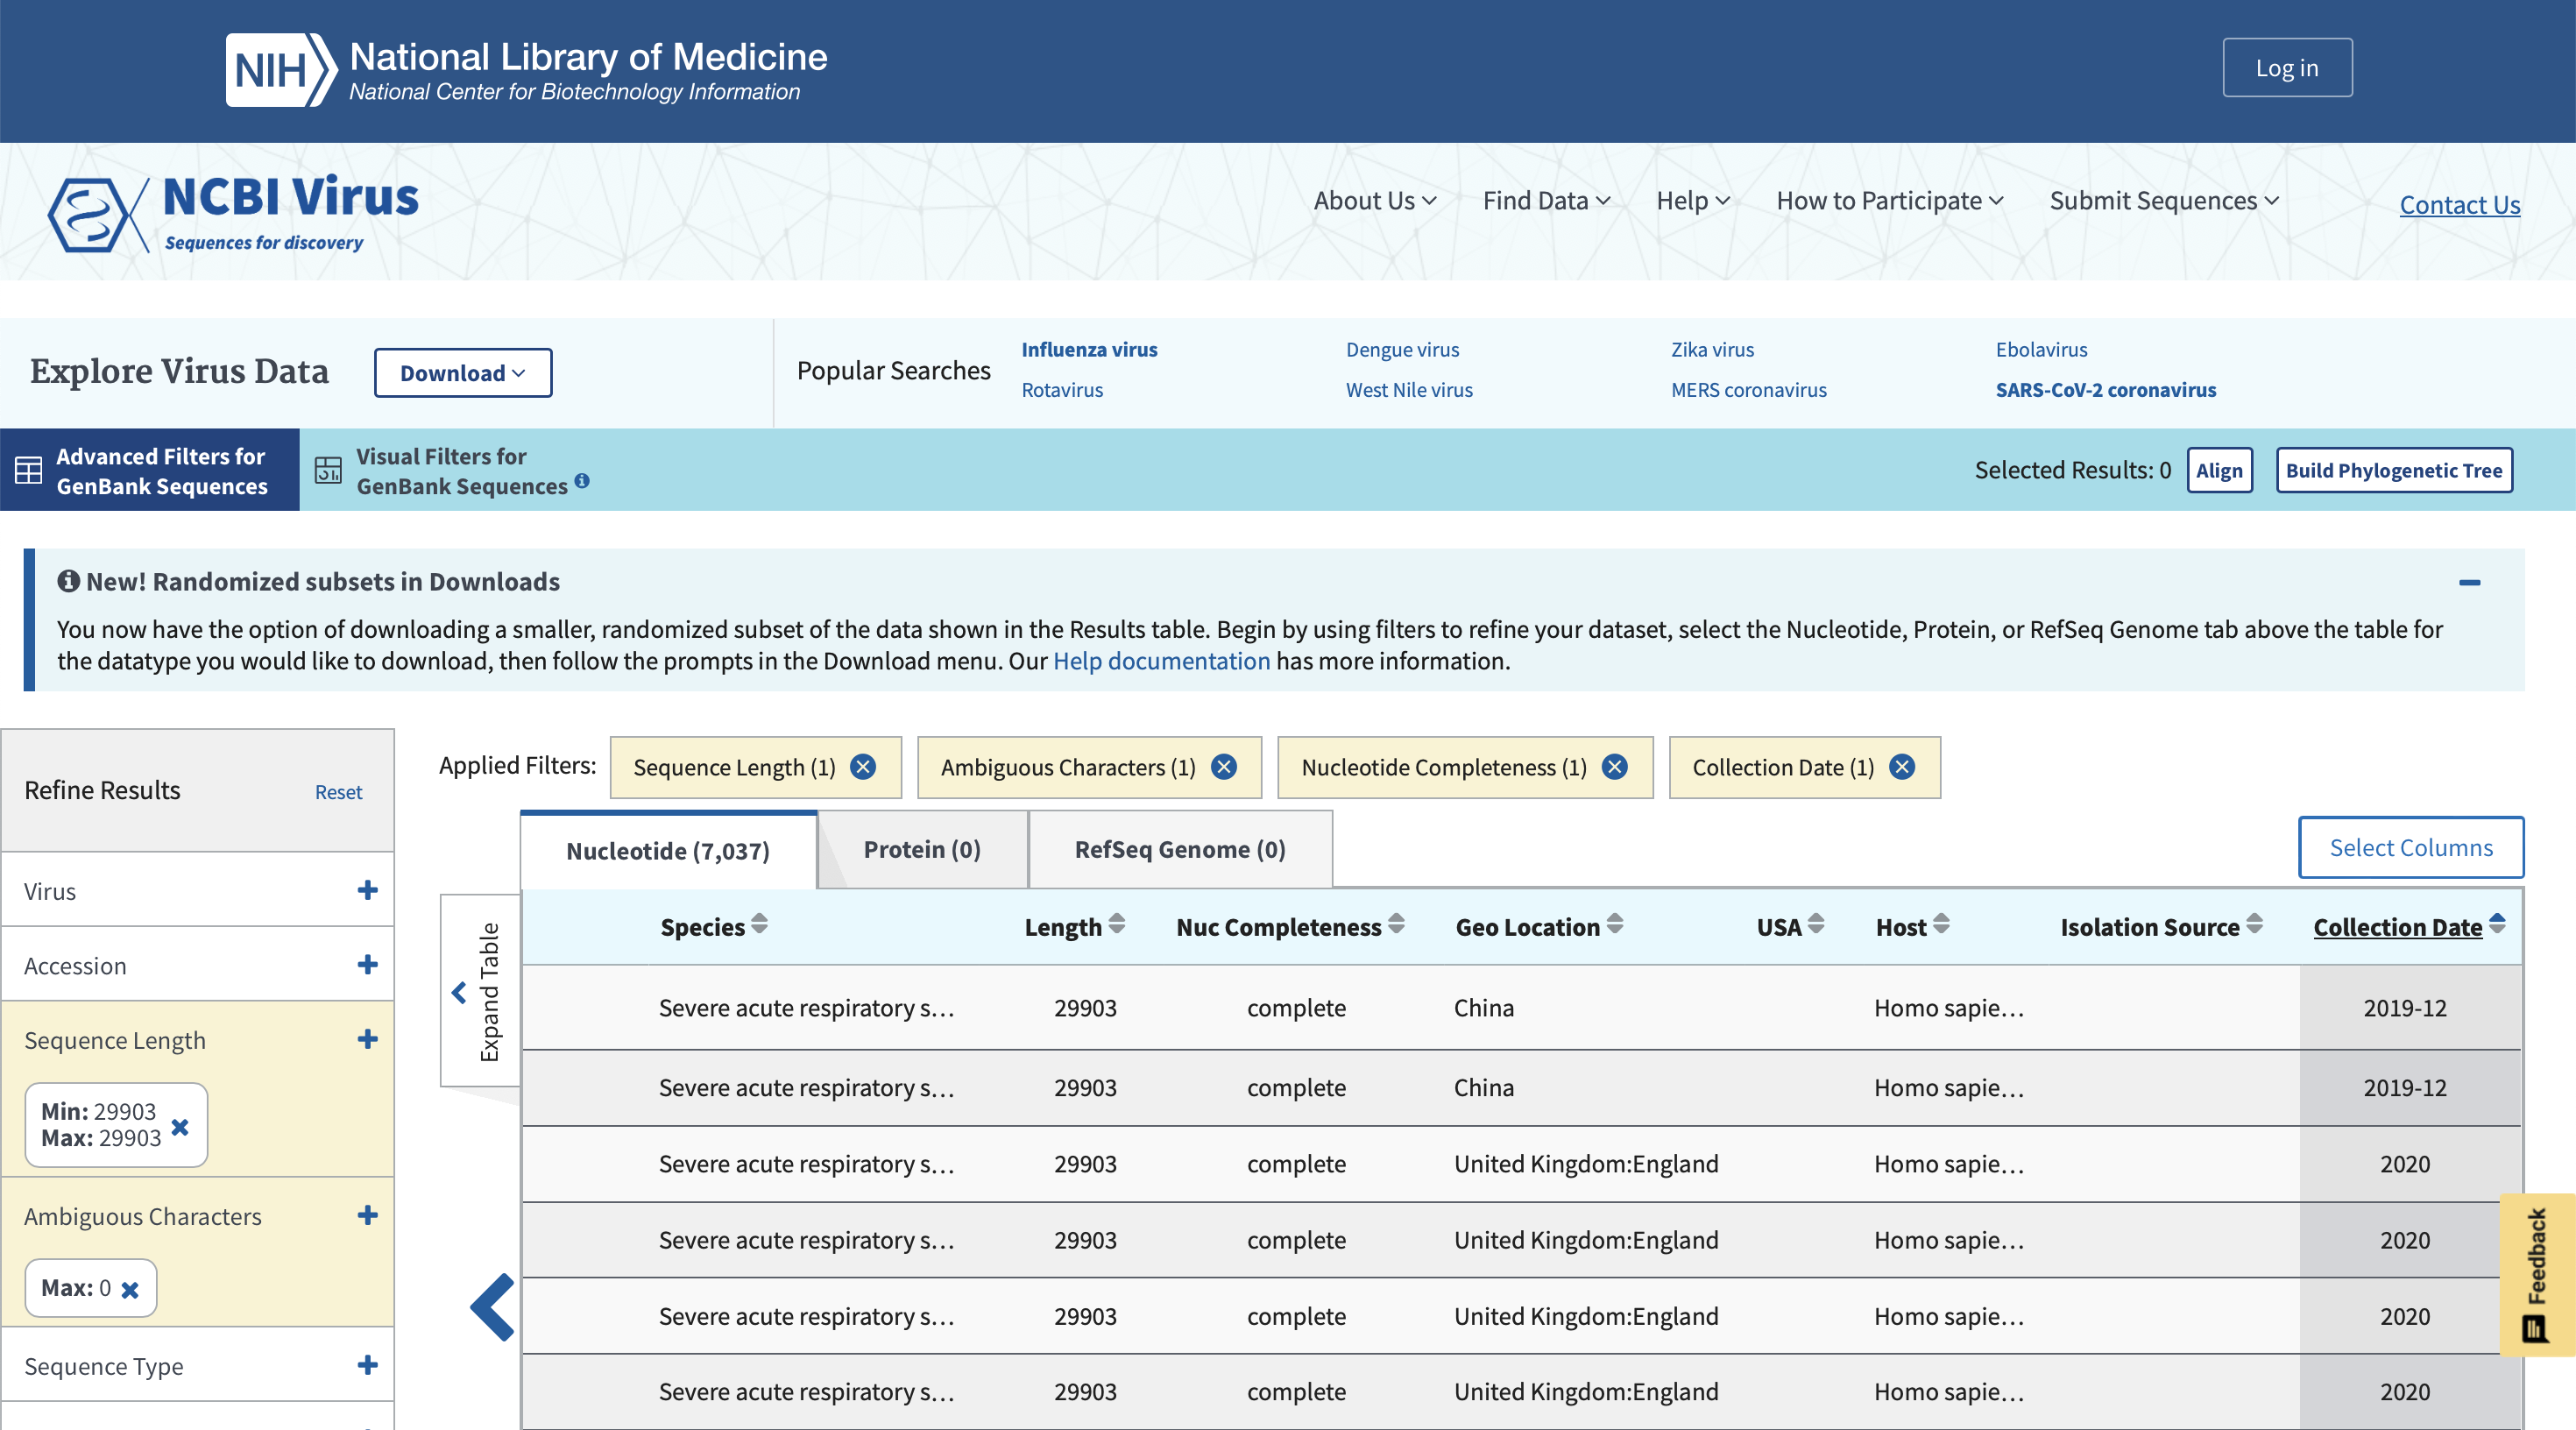
|:---
| Webseite von NCBI Virus



## Download weiterer Genome

- Filtern Sie die Tabelle nach
  - Sequence Length: Min = Max = 29903
  - Nucleotide Completeness: complete
  - Ambiguous Characters: 0
  - Collection Date: From 01/01/2019 To 12/31/2020

- Klicken Sie dann wieder oben auf **Download** (Sie brauchen nicht alle Boxen an den Sequenzen auswählen.)

- Wählen Sie im sich öffnenden Fenster: 

  - 1/3) FASTA Nucleotide
  - 2/3) Download a randomized subset of **10** records (20 or fewer) per category, stratified by **Country** 
  - 3/3) Build Custom: Select _Accession_, _Geo Location_ and _Collection Date_

- Jetzt sollten Sie die FASTA-Datei auf Ihrem Rechner haben

## Upload zu Linux


- Verschieben Sie heruntergeladene Datei in das Verzeichnis _SARS-CoV-2_ und benennen Sie

  - die Datei mit dem Referenzgenom in *NC_045512.2.fasta* um
  
  - die Datei mit den 200 Genomen in *cov2-len-29903.fasta* um
  
Zählen Sie die Anzahl der enthaltenden Sequenzen:

In [ ]:
pwd

In [ ]:
grep -c ">" cov2-len-29903.fasta

---

## Suche nach Mutationen mit AWK

### Download der Scripte

Mit Hilfe von AWK können wir die Genome direkt bearbeiten. Dazu brauchen Sie die zwei Scripte *compare-cov2.awk* und *fasta2tbl* von meiner **GitHub** Seite: https://github.com/awkologist/SARS-CoV-2. Die Scripte können Sie direkt mit `wget` herunterladen:

In [ ]:
wget 'https://raw.githubusercontent.com/awkologist/SARS-CoV-2/main/fasta2tbl'

In [ ]:
wget 'https://raw.githubusercontent.com/awkologist/SARS-CoV-2/main/compare-cov2.awk'

### Umwandlung von FASTA zu TAB

Da AWK Dateien zeilenweise liest und jede Zeile in Felder zerlegt, ist das FASTA-Format nicht gut für die Datenanalyse mit AWK geeignet. Mit den Script `fasta2tbl` wandeln wir daher das FASTA- in das TAB-Format, also mit Tabulatoren als Separatoren.

In [ ]:
./fasta2tbl wuhan-1.fasta > wuhan-1.tab

- Fehlermeldung? Dann müssen wir müssen das Script erst ausführbar machen:

In [ ]:
ls -l fasta2tbl

In [ ]:
chmod u+x fasta2tbl

In [ ]:
ls -l fasta2tbl

In [ ]:
./fasta2tbl cov2-len-29903.fasta > cov2-len-29903.tab

In [ ]:
awk '{print $1}' wuhan-1.tab

### Metadaten aus FASTA als TAB Datei

Jetzt müssen wir noch die Metadaten ins TAB-Format bringen. Diese verwenden wir später im Script `compare-cov2.awk`. Die drei Felder ID, Ort und Datum sind in *cov2-len-29903.fasta* in der *description line* (beginnt mit `>`) durch den *vertical bar* (`|`) getrennt.

Es gibt dort aber problematische Zeilen wie _MW276480,"USA: CA, Marin County",2020-08-26_ und _MW011767,"China: Hunan,Shaoyang",2020-01-29_ -> hier ist jeweils ein Komma in der Ortsbezeichnung, mal mit mal ohne nachfolgendem Leerzeichen. Und die Anführungszeichen wollen wir auch löschen. 

Mit folgendem AWK-Befehl können wir die Metadaten aus der FASTA-Datei extrahieren und als TAB-Datei speichern:

In [ ]:
awk -F"|" '/>/{gsub(/>/,"",$1);gsub(/ /,"_",$2);print $1"\t"$2"\t"$3}' cov2-len-29903.fasta > cov2-len-29903-metadata.tab

In [ ]:
head -3 cov2-len-29903-metadata.tab

Suchen wir zunächst Sequenzen aus Deutschland:

In [ ]:
egrep 'Germany' cov2-len-29903-metadata.tab

Suchen wir jetzt die Referenz und die erste deutsche sequenzierte Probe:

In [ ]:
egrep 'NC_045512|MT358638' cov2-len-29903-metadata.tab

### Vergleich von Genomen
Spielen wir nun mit dem AWK-Skript um zunächst zwei Virengenome zu vergleichen:

In [ ]:
awk -f compare-cov2.awk

In [ ]:
awk -f compare-cov2.awk -v seq=cov2-len-29903.tab -v anno=cov2-len-29903-metadata.tab -v id2=MT358638

Jetzt vergleichen wir alle deutschen Genome gegen Wuhan 1:

In [ ]:
for i in MT358638 MT358639 MT358640 MT358641 MT358642 MT358643; do awk -f compare-cov2.awk -v seq=cov2-len-29903.tab -v anno=cov2-len-29903-metadata.tab -v id2=$i; echo "----"; done

### Zwischenergebnis
Wir sehen, dass die betroffenen Aminosäuren im Spike-Protein und ggf. in der *receptor binding domain* (RBDomain) oder im *receptor binding motif* (RBMotif) liegen. Mutationen im *receptor binding motif* haben die größte Wahrscheinlichkeit, zu einer Veränderung der Infektiosität zuführen. 

### Detailliertere Analyse
Analysieren wir nun alle Sequenzen. Dabei erstellt uns der AWK-Befehl in `$()` die Liste. Achtung, die Ausführung dauert je nach Rechner ein Minütchen oder zwei.

In [ ]:
awk '{gsub(/\.[0-9]/,"",$1); print $1}' cov2-len-29903-metadata.tab | head -5

In [ ]:
time for i in $(awk '{gsub(/\.[0-9]/,"",$1); print $1}' cov2-len-29903-metadata.tab); do awk -f compare-cov2.awk -v seq=cov2-len-29903.tab -v anno=cov2-len-29903.metadata.tab -v id2=$i; echo "# ----"; done > result.txt

Jetzt extrahieren wir alle *receptor binding motif* Mutationen:

In [ ]:
egrep 'Motif' result.txt

Wie unterscheidet sich die Häufigkeit der Mutationen an verschiedenen Positionen?

In [ ]:
awk '$1 !~ /^#/{print $2}' result.txt | sort | uniq -c | sort -nr | head -5

Welche Nukleotidaustausche sind am häufigsten?

In [ ]:
awk '$1 !~ /^#/{print $3}' result.txt | sort | uniq -c | sort -nr | head -5

Und welche betreffen am häufigsten die RBD?

In [ ]:
awk '$1 !~ /^#/ && $9 == "RBDomain"{print $2"_"$6"_"$9"_"$10}' result.txt | sort | uniq -c | sort -nr | head -5

## Projektion auf 3D Struktur
Ein nächster interessanter Schritt wäre die Projektion dieser Daten auf die 3D-Struktur des Proteins. Das freiverfügbare Programm **Jmol** können Sie direkt runterladen. Alternativ können Sie eine Browserversion verwenden.

# Variante 1: Browser

Gehen Sie auf https://chemapps.stolaf.edu/jmol/jsmol/jsmol.htm und öffnen Sie bei *RSCB (macromolecules)* die Struktur **7DF4**.  

Öffnen Sie dann auf den Link *Concole* und führen Sie folgenden Code aus:

```
spacefill off; wireframe off
cartoon
select :A; color lightgray # ACE2
select :C; color gray # Spike 2
select :D; color darkgray # Spike 3
select :B; color lightblue # Spike 1
select 319-541:B; color blue # RBDomain
select 437-508:B; color red # RBMotif
select 501:B,522:B,521:B,479:B,520:B # Mutations
spacefill 300
color yellow
```

Spielen Sie ein bisschen rum.

# Variante 2: Jmol installieren
Dies geht nur auf einem Linux-System mit graphischer Oberfläche:

In [ ]:
wget 'https://sourceforge.net/projects/jmol/files/Jmol/Version%2014.31/Jmol%2014.31.29/Jmol-14.31.29-full.tar.gz'

In [ ]:
tar -xf Jmol-14.31.29-full.tar.gz jmol-14.31.29

Sie können folgende Befehle in eine Textdatei _7DF4.script_schreiben und direkt mit Jmol ausführen als `./jmol-14.31.29/jmol.sh -s 7DF4.script &` ausführen

```
load =7DF4
spacefill off; wireframe off
cartoon
select :A; color lightgray # ACE2
select :C; color gray # Spike 2
select :D; color darkgray # Spike 3
select :B; color lightblue # Spike 1
select 319-541:B; color blue # RBDomain
select 437-508:B; color red # RBMotif
select 501:B,522:B,521:B,479:B,520:B # Mutations
spacefill 300
color yellow
```


| ![Virus DB](Images/spike.png)
|:---
| Das Spikeprotein (hellblau) mit der RBD in blau und dem RBMotif in rot. Violett ist der ACE2-Rezeptor dargestellt. Gelb und hervorgehoben die genetischen Varianten.
(PDB 7DF4; DOI 10.1126/sciadv.abe5575)

---

# Suche nach Mutationen mit BWA, SAM und BCF

Dieses Vorgehen ist für __fortgeschrittene__ Nutzer von Linux und erfolgert die __Installation__ mehrerer Software Tools. Allerdings ist diese Pipeline angelehnt an die Analyse von Sequenzdaten und die Suche nach SNPs und daher universeller einsetzbar. Sie brauchen aber eine Linuxumgebung mit Administratorrechten. Ich verwende dafür die im Mastermodul installierte __virtuelle Maschine mit Ubuntu__. 

Alternativ können Sie mit _Cygwin_ (https://www.cygwin.com) oder der _Ubuntu Emulator_ für Windows 10 (https://ubuntu.com/tutorials/ubuntu-on-windows#1-overview) verwendet werden.



- Als erstes Alignieren wir die SARS-CoV-2 Genome mit __BWA__ mit dem Referenzgenom. Dazu müssen wir einen Index erstellen, damit das Programm BWA auf die Daten zugreifen kann. Dabei werden einige Dateien erstellt.

In [ ]:
! bwa index NC_045512.2.fasta

- dann folgt das eigentliche Alignment

In [ ]:
! bwa mem NC_045512.2.fasta cov2-len-29903.fasta > alignment.sam

- Jetzt muss die SAM-Datei mit __SamTools__ in eine binäre BAM-Datei umgewandelt werden. Die Option `-b` besagt, das die Ausgabe im BAM-Format sein soll.

In [ ]:
! samtools view -b alignment.sam > alignment.sam.bam

- jetzt folgt ein Sortierschritt für den schnelleren Datenzugriff

In [ ]:
! samtools sort alignment.sam.bam > alignment.sam.sorted.bam

- es folgen eine Indexierung des Referenzgenoms (`faidx`) und die Suche nach Sequenzunterschieden (`mpileup`) mit __SamTools__ und die Erstellung einer Datei im VCF-Format (_variant calling format_) mit __BcfTools__ (`view`)

In [ ]:
! samtools faidx NC_045512.2.fasta

In [ ]:
! bcftools mpileup -d 2000 -f NC_045512.2.fasta alignment.sam.sorted.bam > alignment.bcf

In [ ]:
! bcftools call --variants-only --multiallelic-caller --ploidy 1 -o alignment.variants.vcf alignment.bcf

In [ ]:
! awk '$1 !~ /^##/{OFS="\t"; print $2,$4,$5,$6}' alignment.variants.vcf

Das Ergbnis zeigt, dass bspw. an Position 241 im Referenzgenom ein C, in den meisten anderen Genomen aber ein T vorliegt. Die Qualität _QUAL_ liegt als sogenannter Phred-Score vor. Einer Fehlerwahrscheinlichkeit E von 10% entspricht ein Quality-Score Q von 10; von 1% -> 20; von 0.1% -> 30. Es gilt E=10^(-Q/10) und Q=-10xlogE.

Natürlich liefert uns diese Pipeline nur häufige SNPs, denn sie ist eigentlich für die Suche nach relevanten Mutationen (SNPs) in größeren Populationen gedacht.

Im Falle von Viren, können aber auch sehr seltene Varianten schnell Verbreitung finden. Diese finden wir zum Beispiel mit der oben dargestellten AWK-Variante.